In [1]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO

In [2]:
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')

In [3]:
# get team to logo URL datframe
team_logoURL = pd.read_csv("./data/team_logos.csv")

In [32]:
team = 'SF'
season = 2022
week = 4
cols = ['game_id','play_id','epa','season_type','season','week','drive','series','down','ydstogo','wp','ep','yardline_100','home_team','away_team','posteam','defteam','game_seconds_remaining','game_half','fixed_drive_result','penalty_team', 'penalty_type','penalty_yards']#'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']
df_pbp = nfl.import_pbp_data(years=[season], columns=cols, downcast=True, cache=False)
logoURL = team_logoURL[team_logoURL['team_abbr'] == team].team_logo_wikipedia.tolist()[0]
team_nick = team_logoURL[team_logoURL['team_abbr'] == team].team_nick.tolist()[0]

2022 done.
Downcasting floats.


In [33]:
def get_offensive_drives(df, team, week):
    conditional_team = (df['posteam'] == team)
    conditional_week = (df['week'] == week)
    is_down = (df['down'].notnull())
    return df[conditional_team & conditional_week & is_down]

df_team_week_plays = get_offensive_drives(df_pbp, team, week)

In [34]:
df_team_week_plays[df_team_week_plays.penalty_yards.notnull()]

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,wp,...,away_team,posteam,defteam,game_seconds_remaining,game_half,fixed_drive_result,penalty_team,penalty_type,penalty_yards,season
9862,2022_04_LA_SF,2779.0,-1.813943,REG,4,13.0,38.0,4.0,1.0,0.842986,...,LA,SF,LA,896.0,Half2,Field goal,SF,Delay of Game,5.0,2022
9870,2022_04_LA_SF,3041.0,-1.008206,REG,4,15.0,40.0,2.0,7.0,0.903542,...,LA,SF,LA,757.0,Half2,Missed field goal,SF,Offensive Holding,10.0,2022


In [6]:
def get_teams(df):
    """
        return first listed home and away teams
        from list of unique team names in 
        the nflreadr play by play dataframe
    """
    home_team = df.home_team.unique()[0]
    away_team = df.away_team.unique()[0]
    return home_team, away_team

def get_team_info(df, team):
    """
        return URLs specific to the team
        from nflreadr teams dataframe
    """
    teamname = df[df['team_abbr'] == team].team_name.tolist()[0]
    wordmarkURL = df[df['team_abbr'] == team].team_wordmark.tolist()[0]
    team_color1 = df[df['team_abbr'] == team].team_color.tolist()[0]
    team_color2 = df[df['team_abbr'] == team].team_color2.tolist()[0]
    team_color3 = df[df['team_abbr'] == team].team_color3.tolist()[0]
    return teamname, wordmarkURL, [team_color1, team_color2, team_color3]
    
home_team, away_team = get_teams(df_team_week_plays)

home_teamname, home_wordmarkURL, home_teamcolors = get_team_info(team_logoURL, home_team)
away_teamname, away_wordmarkURL, away_teamcolors = get_team_info(team_logoURL, away_team)

In [7]:
srs_team_weeks_sums = df_team_week_plays.groupby(['drive']).agg({'epa':'sum','ep':'sum','posteam':'count'})
(srs_team_weeks_sums.ep/srs_team_weeks_sums.posteam).sum(axis=0)

12.911866107228256

In [8]:
home_team_wordmark = team_logoURL[team_logoURL['team_abbr'] == home_team].team_color.tolist()[0]

df_drives_results_halfs = df_team_week_plays[['drive','fixed_drive_result','game_half']].drop_duplicates(['drive','fixed_drive_result'])
drives = df_drives_results_halfs['drive'].tolist()
drives_idxs = np.arange(1,len(drives)+1).tolist()
results = df_drives_results_halfs['fixed_drive_result'].tolist()
height_ratios=[1]*(len(drives))

game_halfs = df_drives_results_halfs['game_half'].tolist()
half_idx = game_halfs.index('Half2')
game_halfs.insert(half_idx, '[  halftime  ]')
drives.insert(half_idx, -1)
drives_idxs.insert(half_idx, -1)
results.insert(half_idx, '')
height_ratios.insert(half_idx,0.1)

try:
    overtime_idx = game_halfs.index('Overtime')
    game_halfs.insert(overtime_idx, '[  overtime  ]')
    drives.insert(overtime_idx, -1)
    drives_idxs.insert(overtime_idx, -1)
    results.insert(overtime_idx, '')
    height_ratios.insert(overtime_idx,0.1)
except ValueError:
    print("no overtime period drives detected in this game")

league_epa_min =df_pbp.epa.min()
league_epa_max =df_pbp.epa.max()
game_epa_min =df_team_week_plays.epa.min()
game_epa_max =df_team_week_plays.epa.max()

no overtime period drives detected in this game


In [107]:
game_halfs

['Half1',
 'Half1',
 'Half1',
 'Half1',
 'Half1',
 '[  halftime  ]',
 'Half2',
 'Half2',
 'Half2',
 'Half2']

In [10]:
def format_drive_result(drive_result):  
    if drive_result in ["Touchdown", "Opp touchdown"]:
        drive_result = drive_result + "!"
    return " " + drive_result.upper()
    

In [11]:
# adjust coloring of downs?
# How do I want to convey personnel, down and distance, results of drive?

# FONT FAMILY
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = pm_text

# COLOR
background = "#343434"#"#444148"
text_color = "#F8F9F9"
filler_color = "grey"
drive_start_color = "lightgrey"
drive_end_color = "lightgrey"
# touchdown_color = "#CFF3F2"
color_map = "Spectral"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

# TEXT
title = "Quicklook:  {}' Offensive Drives\n<NFL {} WEEK {}>    <{}> <@> <{}>"
drive_title = "drive no.{}"
# subtitle = "NFL {} WEEK {}    <{}> <@> <{}>"
credits = "created: keegan heilman / @keeganheilman\ndata: nflreadr (https://github.com/nflverse) via nfl_data_py (https://github.com/cooperdff/nfl_data_py)"

10 22


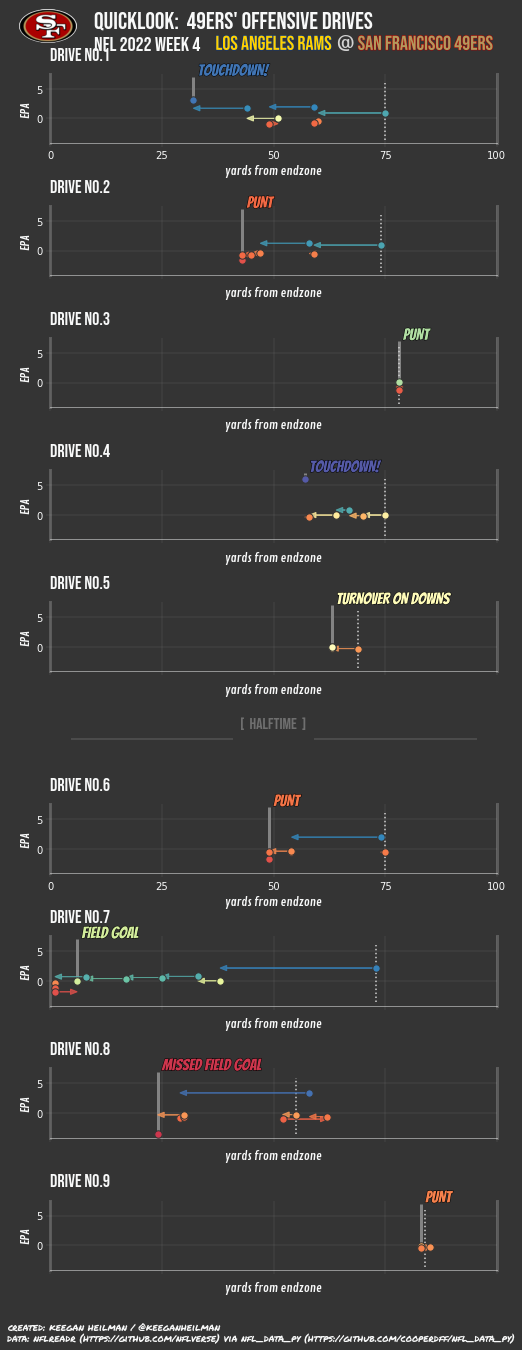

In [38]:
# plot figure, axs

fig_height = round(24/11*len(drives))
first_drive_of_half = True


print(len(drives),fig_height)

fig = plt.figure(figsize=(8,fig_height))
gs = fig.add_gridspec(len(drives), hspace=1, height_ratios=height_ratios)
# gs = fig.add_gridspec(len(drives),2, hspace=1, height_ratios=height_ratios, width_ratios=[2,1])
# fig.subplots_adjust(wspace=0.1)
axs = gs.subplots(sharex=False, sharey=True)
fig.set_facecolor(background)

cmap = matplotlib.cm.get_cmap(color_map)
norm = mpl.colors.SymLogNorm(linthresh=0.1, vmin=league_epa_min, vmax=league_epa_max)

for axs_idx, (drive, drive_idx, drive_result, game_half) in enumerate(zip(drives, drives_idxs, results, game_halfs)):
    
    if game_half in ['[  halftime  ]','[  overtime  ]']:
        axs[axs_idx].patch.set_facecolor(background)
        axs[axs_idx].set_title(label=game_half, color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=16, alpha=0.3)
        axs[axs_idx].axis("off")
        axs[axs_idx].hlines(y=[-1], xmin=0, xmax=40, colors=[drive_start_color],linestyles="solid", alpha=0.2)
        axs[axs_idx].hlines(y=[-1], xmin=60, xmax=100, colors=[drive_start_color],linestyles="solid", alpha=0.2)
        first_drive_of_half = True
    else:
        x = df_team_week_plays[df_team_week_plays.drive == drive].yardline_100.tolist()
        y = df_team_week_plays[df_team_week_plays.drive == drive].epa.tolist()
        axs[axs_idx].patch.set_facecolor(background)
        axs[axs_idx].grid(ls="-", lw=0.2, color="#838383", zorder=-10)
        axs[axs_idx].set_title(drive_title.format(drive_idx),pad=14,loc="left", color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
        axs[axs_idx].set_xlim(0,100)
        if not first_drive_of_half:
            axs[axs_idx].set_xticklabels([])
        axs[axs_idx].set_xlabel("yards from endzone",color=text_color,fontfamily=axs_label_text, fontsize=12)
        axs[axs_idx].set_ylabel("EPA",color=text_color,fontfamily=axs_label_text, fontsize=12)
        axs[axs_idx].tick_params(axis="both",length=4, width=0.2, color="#838383")
        axs[axs_idx].xaxis.set_major_locator(plt.MaxNLocator(4))
      
        spines = ["top", "right", "bottom", "left"]
        for s in spines:
            if s in ["top"]:
                axs[axs_idx].spines[s].set_visible(False)
            elif s in ["left", "right"]:
                axs[axs_idx].spines[s].set_color(text_color)
                axs[axs_idx].spines[s].set_linewidth(3)
                axs[axs_idx].spines[s].set_alpha(.2)
            else:
                axs[axs_idx].spines[s].set_color(text_color)
                axs[axs_idx].spines[s].set_alpha(.6)



        for point_idx, (x_val, y_val) in enumerate(zip(x,y)):
            cmap_point_color = (cmap(norm(y_val)))
            if point_idx < len(x)-1:
                if point_idx == 0:
                    axs[axs_idx].vlines(x_val, ymin=game_epa_min, ymax=game_epa_max, colors=[drive_start_color], linestyles="dotted")
                axs[axs_idx].arrow(x_val,y_val,
                                     x[point_idx+1]-x_val,0,
                                     color=(cmap(norm(y[point_idx]))),
                                     shape="full",
                                     length_includes_head=True,
                                     head_width=0.9,
                                     head_length=1.5,
                                     capstyle="butt",
                                     alpha=0.8,
                                     lw=1,
                                     zorder=5)
            # plot end of drive information
            if point_idx == len(x)-1:
                # plot vertical line at end of drive point
                end_of_drive_line = axs[axs_idx].vlines(x_val, ymin=y_val,ymax=game_epa_max+1,
                                                          colors=[drive_end_color],
                                                          linestyles="solid",
                                                        lw=3,
                                                          alpha=0.5,
                                                          zorder=-5)
                end_of_drive_line.set_path_effects([path_effects.withStroke(linewidth=0, foreground="white")])
                # plot end of drive result text (e.g. "TOUCHDOWN!") 
                drive_result_t= axs[axs_idx].text(x=x_val+0.3,y=game_epa_max+1.2,
                                                        s=format_drive_result(drive_result),
                                                        color=cmap_point_color,
                                                        fontfamily=touchdown_text,
                                                        fontsize=16)
                drive_result_t.set_path_effects([path_effects.withStroke(linewidth=1, foreground="black")])
            # plot play point x=epa, y=yardline_100
            axs[axs_idx].scatter(x_val,y_val, color=cmap_point_color,edgecolors=background,s=55, alpha=1,lw=1,zorder=10)
            first_drive_of_half = False
        
# plot figure title
title_t = htext.fig_text(s=title.format(team_nick, season, week, away_teamname, home_teamname),
               x=0.2,y=0.92,
               highlight_textprops=[{"fontsize":20, "color": text_color},
                                    {"fontsize":20, "color": away_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=1, foreground=away_teamcolors[0])]},
                                    {"fontsize":20, "color": "lightgrey", "fontfamily":subtitle_text},
                                    {"fontsize":20, "color": home_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=1, foreground=home_teamcolors[0])]}],
               color=text_color,
               fontsize=24,
               fontfamily=title_text)
            

# add axis and plot logo
ax2 = fig.add_axes([0.07,0.86,0.10,0.10])
ax2.axis("off")
url = logoURL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)
             
# plot credits
fig.text(0.05, 0.08,
         s=credits,
         fontstyle="italic",
         fontweight="light",
         fontsize=10,
         fontfamily=credits_text,
         color=text_color)
    

plt.show()
fig.savefig(f'{season}-WEEK{week}-{team}.png',bbox_inches='tight', dpi=600)
# plt.close('all')

In [13]:
# # confirm font family is added
# from IPython.core.display import HTML
# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [23]:
df_par = pd.read_csv(f'data/pbp_participation_{season}.csv')
df_par.offense_personnel

0                    NaN
1                    NaN
2       1 RB, 1 TE, 3 WR
3       1 RB, 1 TE, 3 WR
4       2 RB, 1 TE, 2 WR
              ...       
5848                 NaN
5849                 NaN
5850                 NaN
5851    1 RB, 1 TE, 3 WR
5852                 NaN
Name: offense_personnel, Length: 5853, dtype: object

In [15]:
def merge_play_par(df_play, df_par):
    return pd.merge(df_play, df_par, how='left', left_on=['game_id','play_id'], right_on=['nflverse_game_id','play_id'])

df_play_par = merge_play_par(df_team_week_plays, df_par)

In [16]:
def extract_opersonnel(pers):
    re_ST_pattern = re.compile('(ST)')
    re_OL_pattern = re.compile('(\d) OL')
    re_RB_pattern = re.compile('(\d) RB')
    re_TE_pattern = re.compile('(\d) TE')
    re_WR_pattern = re.compile('(\d) WR')
    return {'ST':re_ST_pattern.findall(pers)[0] if len(re_ST_pattern.findall(pers)) == 1 else '',
           'OL':str(int(re_OL_pattern.findall(pers)[0])-5) if len(re_OL_pattern.findall(pers)) == 1 else '',
           'RB':re_RB_pattern.findall(pers)[0] if len(re_RB_pattern.findall(pers)) == 1 else '',
           'TE':re_TE_pattern.findall(pers)[0] if len(re_TE_pattern.findall(pers)) == 1 else '',
           'WR':re_WR_pattern.findall(pers)[0] if len(re_WR_pattern.findall(pers)) == 1 else ''}

def extract_dpersonnel(pers):
    re_ST_pattern = re.compile('(ST)')
    re_DL_pattern = re.compile('(\d) DL')
    re_LB_pattern = re.compile('(\d) LB')
    re_DB_pattern = re.compile('(\d) DB')
    return {
           'DL':re_DL_pattern.findall(pers)[0] if len(re_DL_pattern.findall(pers)) == 1 else '',
           'LB':re_LB_pattern.findall(pers)[0] if len(re_LB_pattern.findall(pers)) == 1 else '',
           'DB':re_DB_pattern.findall(pers)[0] if len(re_DB_pattern.findall(pers)) == 1 else ''}


df_play_par.loc[df_play_par['offense_personnel'].isnull(), 'offense_personnel'] = 'ST'
df_play_par.loc[df_play_par['defense_personnel'].isnull(), 'defense_personnel'] = 'ST'
df_play_par = df_play_par.merge(pd.DataFrame.from_records(df_play_par['offense_personnel'].apply(extract_opersonnel)), how='left', left_index=True, right_index=True)
df_play_par = df_play_par.merge(pd.DataFrame.from_records(df_play_par['defense_personnel'].apply(extract_dpersonnel)), how='left', left_index=True, right_index=True)
df_play_par

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,wp,...,n_offense,n_defense,ST,OL,RB,TE,WR,DL,LB,DB
0,2022_04_LA_SF,438.0,0.929404,REG,4,2.0,6.0,1.0,10.0,0.511088,...,NaN,NaN,ST,,,,,,,
1,2022_04_LA_SF,470.0,-0.451762,REG,4,2.0,7.0,1.0,10.0,0.540658,...,NaN,NaN,ST,,,,,,,
2,2022_04_LA_SF,499.0,-0.803238,REG,4,2.0,7.0,2.0,9.0,0.523858,...,NaN,NaN,ST,,,,,,,
3,2022_04_LA_SF,521.0,1.958104,REG,4,2.0,7.0,3.0,9.0,0.491509,...,NaN,NaN,ST,,,,,,,
4,2022_04_LA_SF,545.0,-0.877076,REG,4,2.0,8.0,1.0,10.0,0.552725,...,NaN,NaN,ST,,,,,,,
5,2022_04_LA_SF,566.0,0.013722,REG,4,2.0,8.0,2.0,12.0,0.527802,...,NaN,NaN,ST,,,,,,,
6,2022_04_LA_SF,599.0,1.723389,REG,4,2.0,8.0,3.0,5.0,0.559873,...,NaN,NaN,ST,,,,,,,
7,2022_04_LA_SF,623.0,3.103022,REG,4,2.0,9.0,1.0,10.0,0.608968,...,NaN,NaN,ST,,,,,,,
8,2022_04_LA_SF,775.0,0.930373,REG,4,4.0,11.0,1.0,10.0,0.722728,...,NaN,NaN,ST,,,,,,,
9,2022_04_LA_SF,799.0,-0.496138,REG,4,4.0,12.0,1.0,10.0,0.745863,...,NaN,NaN,ST,,,,,,,


In [17]:
df_drive_pers_epa = df_play_par.groupby(['drive','series','ST','OL','RB','TE','WR','DL','LB','DB','down']).agg({'ydstogo':'median','epa':'sum'}).sort_values(['drive','series','down']).reset_index()
df_drive_pers_epa

,drive,series,ST,OL,RB,TE,WR,DL,LB,DB,down,ydstogo,epa
0,2.0,6.0,ST,,,,,,,,1.0,10.0,0.929404
1,2.0,7.0,ST,,,,,,,,1.0,10.0,-0.451762
2,2.0,7.0,ST,,,,,,,,2.0,9.0,-0.803238
3,2.0,7.0,ST,,,,,,,,3.0,9.0,1.958104
4,2.0,8.0,ST,,,,,,,,1.0,10.0,-0.877076
5,2.0,8.0,ST,,,,,,,,2.0,12.0,0.013722
6,2.0,8.0,ST,,,,,,,,3.0,5.0,1.723389
7,2.0,9.0,ST,,,,,,,,1.0,10.0,3.103022
8,4.0,11.0,ST,,,,,,,,1.0,10.0,0.930373
9,4.0,12.0,ST,,,,,,,,1.0,10.0,-0.496138


In [18]:
cols = len(df_drive_pers_epa.columns)

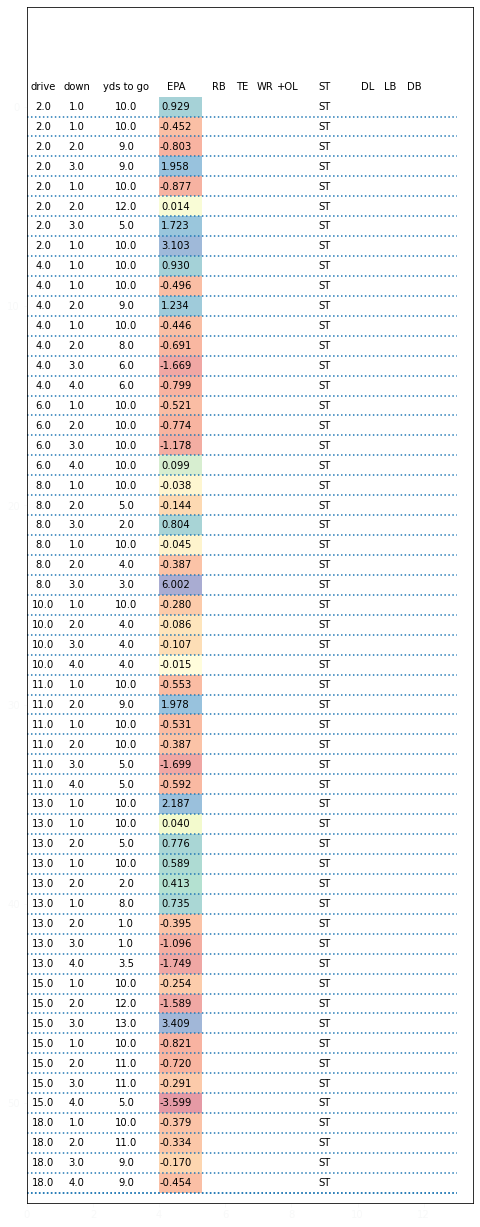

In [19]:
tbl_dist_left_margin = 0.5
tbl_dist_btwn_cols = 0.5

down_factor = 0.5
ytg_factor = 1
epa_factor = 1
opers_factor = 0.7
ST_factor = 1
dpers_factor = 0.7

tbl_down_dist = 1
tbl_ytg_dist = 1
tbl_epa_dist = 1.5
tbl_opers_dist = 3
tbl_ST_dist = 1
tbl_dpers_dist = 4

tbl_halign = 'center'



fig, ax = plt.subplots(figsize=(8,fig_height))
rows = df_drive_pers_epa.shape[0]
cols = df_drive_pers_epa.shape[1]

ax.set_ylim(rows, -5)
ax.set_xlim(0, cols + .5)

# plot rows of plays
for row_idx, row in df_drive_pers_epa.iterrows():
    cmap_point_color = (cmap(norm(row['epa'])))
    ax.text(x=0+tbl_dist_left_margin, y=row_idx, s=row['drive'], va='center', ha=tbl_halign)
    ax.text(x=(1*down_factor)+tbl_down_dist, y=row_idx, s=row['down'], va='center', ha=tbl_halign)
    ax.text(x=(2*ytg_factor)+tbl_ytg_dist, y=row_idx, s=row['ydstogo'], va='center', ha=tbl_halign)
    ax.text(x=(3*epa_factor)+tbl_epa_dist, y=row_idx, s= f"{row['epa']:.3f}", va='center', ha=tbl_halign)
    ax.text(x=(4*opers_factor)+tbl_opers_dist, y=row_idx, s=row['RB'], va='center', ha=tbl_halign)
    ax.text(x=(5*opers_factor)+tbl_opers_dist, y=row_idx, s=row['TE'], va='center', ha=tbl_halign)
    ax.text(x=(6*opers_factor)+tbl_opers_dist, y=row_idx, s=row['WR'], va='center', ha=tbl_halign)
    ax.text(x=(7*opers_factor)+tbl_opers_dist, y=row_idx, s=row['OL'], va='center', ha=tbl_halign)
    ax.text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=row['ST'], va='center', ha=tbl_halign)
    ax.text(x=(9*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DL'], va='center', ha=tbl_halign)
    ax.text(x=(10*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['LB'], va='center', ha=tbl_halign)
    ax.text(x=(11*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DB'], va='center', ha=tbl_halign)
    rect = mpl.patches.Rectangle(((3*epa_factor)+tbl_epa_dist-tbl_dist_btwn_cols,row_idx-0.5),width=((4*opers_factor)+tbl_opers_dist)-((3*epa_factor)+tbl_epa_dist), height=1, ec=None,fc=cmap_point_color, alpha=0.5)
    ax.add_patch(rect)
    ax.hlines(xmin=0, xmax=cols, y=row_idx+0.5, linestyles="dotted")
    
    

# add headers
ax.text(x=0+tbl_dist_left_margin, y=-1, s="drive", va='center', ha=tbl_halign)
ax.text(x=(1*down_factor)+tbl_down_dist, y=-1, s='down', va='center', ha=tbl_halign)
ax.text(x=(2*ytg_factor)+tbl_ytg_dist, y=-1, s='yds to go', va='center', ha=tbl_halign)
ax.text(x=(3*epa_factor)+tbl_epa_dist, y=-1, s="EPA", va='center', ha=tbl_halign)
ax.text(x=(4*opers_factor)+tbl_opers_dist, y=-1, s='RB', va='center', ha=tbl_halign)
ax.text(x=(5*opers_factor)+tbl_opers_dist, y=-1, s='TE', va='center', ha=tbl_halign)
ax.text(x=(6*opers_factor)+tbl_opers_dist, y=-1, s='WR', va='center', ha=tbl_halign)
ax.text(x=(7*opers_factor)+tbl_opers_dist, y=-1, s='+OL', va='center', ha=tbl_halign)
ax.text(x=(8*ST_factor)+tbl_ST_dist, y=-1, s='ST', va='center', ha=tbl_halign)
ax.text(x=(9*dpers_factor)+tbl_dpers_dist, y=-1, s='DL', va='center', ha=tbl_halign)
ax.text(x=(10*dpers_factor)+tbl_dpers_dist, y=-1, s='LB', va='center', ha=tbl_halign)
ax.text(x=(11*dpers_factor)+tbl_dpers_dist, y=-1, s='DB', va='center', ha=tbl_halign)
ax.hlines(xmin=0, xmax=cols, y=row_idx+0.5, linestyles="dotted")



# ax.axis("off")    

plt.show()


no overtime period drives detected in this game
12 12
header
playlist
1
2
3
4
5
[  halftime  ]
6
7
8
9
footer


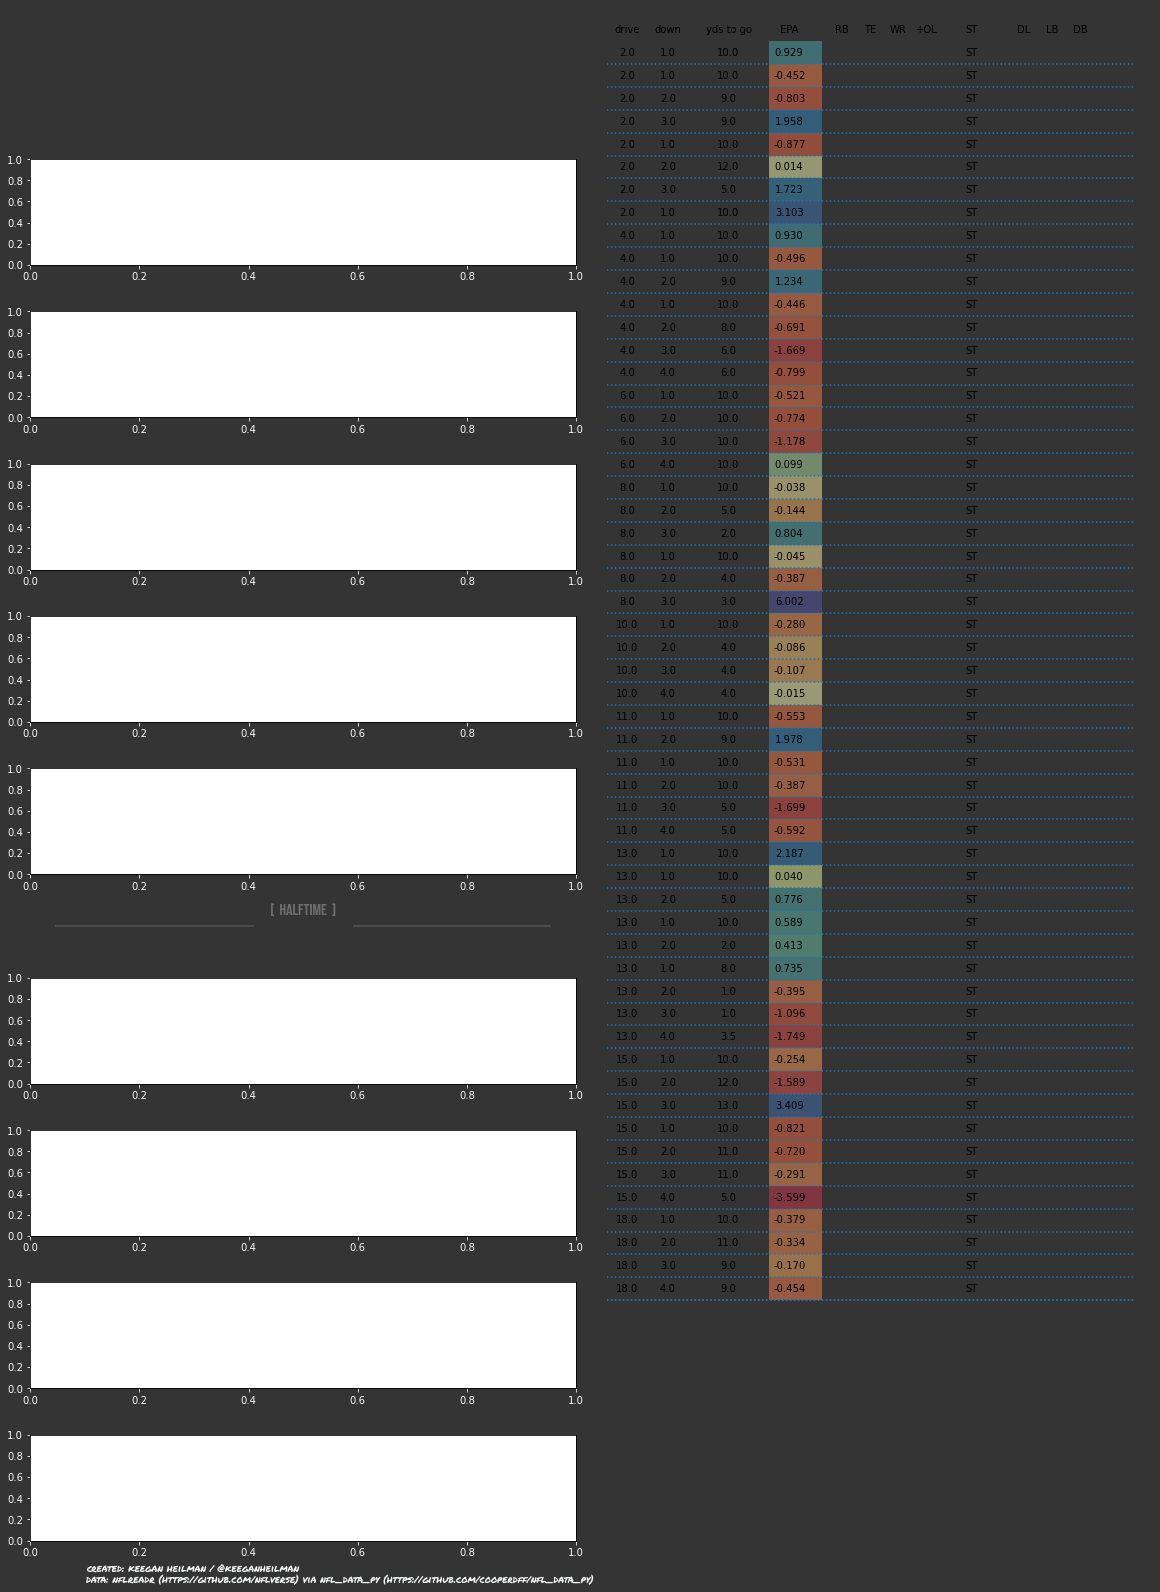

In [127]:
# FOR TEST

df_drives_results_halfs = df_play_par[['drive','fixed_drive_result','game_half']].drop_duplicates(['drive','fixed_drive_result'])
drives = df_drives_results_halfs['drive'].tolist()
axd_idxs = np.arange(1,len(drives)+1).tolist()
height_ratios=[1]*(len(drives))

game_halfs = df_drives_results_halfs['game_half'].tolist()
half_idx = game_halfs.index('Half2')
axd_idxs.insert(half_idx, '[  halftime  ]')
drives.insert(half_idx, -1)
height_ratios.insert(half_idx,0.1)

try:
    overtime_idx = game_halfs.index('Overtime')
    axd_idxs.insert(overtime_idx, '[  overtime  ]')
    drives.insert(overtime_idx, -1)
    height_ratios.insert(overtime_idx,0.1)
except ValueError:
    print("no overtime period drives detected in this game")

    
# add height_ratio for header
height_ratios.insert(0,1)
# add height_ratio for footer
height_ratios.append(0.2)
    

# plot figure, axs

fig_height = round(24/11*len(drives))
gs_kw = dict(width_ratios=[1,1], height_ratios=height_ratios)
cmap = matplotlib.cm.get_cmap(color_map)
norm = mpl.colors.SymLogNorm(linthresh=0.1, vmin=league_epa_min, vmax=league_epa_max)
first_drive_of_half = True


def create_subplot_structure(axd_idxs):
    # initial empty subplot structure
    axs  = [['header','playlist']] 
    # create field subplot structure
    for axd_idx in axd_idxs:  
            subplot = [axd_idx,'playlist']
            axs.append(subplot)
    axs.append(['footer', 'footer'])
    return axs


print(len(height_ratios), len(axs))
axs = create_subplot_structure(axd_idxs)
fig, axd = plt.subplot_mosaic(axs, gridspec_kw=gs_kw, figsize=(16,fig_height), layout="constrained")
fig.set_facecolor(background)


for k in axd:
    print(k)
    if k == 'header':
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        
    elif k == 'footer':
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        # add credits
        axd[k].text(0.05, 0.08,
         s=credits,
         fontstyle="italic",
         fontweight="light",
         fontsize=10,
         fontfamily=credits_text,
         color=text_color)

    if k == 'playlist':
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        rows = df_drive_pers_epa.shape[0]
        cols = df_drive_pers_epa.shape[1]

        axd[k].set_ylim(rows+len(drives), -2)
        axd[k].set_xlim(0, cols + .5)

        # plot rows of plays
        for row_idx, row in df_drive_pers_epa.iterrows():
            cmap_point_color = (cmap(norm(row['epa'])))
            axd[k].text(x=0+tbl_dist_left_margin, y=row_idx, s=row['drive'], va='center', ha=tbl_halign)
            axd[k].text(x=(1*down_factor)+tbl_down_dist, y=row_idx, s=row['down'], va='center', ha=tbl_halign)
            axd[k].text(x=(2*ytg_factor)+tbl_ytg_dist, y=row_idx, s=row['ydstogo'], va='center', ha=tbl_halign)
            axd[k].text(x=(3*epa_factor)+tbl_epa_dist, y=row_idx, s= f"{row['epa']:.3f}", va='center', ha=tbl_halign)
            axd[k].text(x=(4*opers_factor)+tbl_opers_dist, y=row_idx, s=row['RB'], va='center', ha=tbl_halign)
            axd[k].text(x=(5*opers_factor)+tbl_opers_dist, y=row_idx, s=row['TE'], va='center', ha=tbl_halign)
            axd[k].text(x=(6*opers_factor)+tbl_opers_dist, y=row_idx, s=row['WR'], va='center', ha=tbl_halign)
            axd[k].text(x=(7*opers_factor)+tbl_opers_dist, y=row_idx, s=row['OL'], va='center', ha=tbl_halign)
            axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=row['ST'], va='center', ha=tbl_halign)
            axd[k].text(x=(9*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DL'], va='center', ha=tbl_halign)
            axd[k].text(x=(10*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['LB'], va='center', ha=tbl_halign)
            axd[k].text(x=(11*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DB'], va='center', ha=tbl_halign)
            rect = mpl.patches.Rectangle(((3*epa_factor)+tbl_epa_dist-tbl_dist_btwn_cols,row_idx-0.5),width=((4*opers_factor)+tbl_opers_dist)-((3*epa_factor)+tbl_epa_dist), height=1, ec=None,fc=cmap_point_color, alpha=0.5)
            axd[k].add_patch(rect)
            axd[k].hlines(xmin=0, xmax=cols, y=row_idx+0.5, linestyles="dotted")
        # add headers
        axd[k].text(x=0+tbl_dist_left_margin, y=-1, s="drive", va='center', ha=tbl_halign)
        axd[k].text(x=(1*down_factor)+tbl_down_dist, y=-1, s='down', va='center', ha=tbl_halign)
        axd[k].text(x=(2*ytg_factor)+tbl_ytg_dist, y=-1, s='yds to go', va='center', ha=tbl_halign)
        axd[k].text(x=(3*epa_factor)+tbl_epa_dist, y=-1, s="EPA", va='center', ha=tbl_halign)
        axd[k].text(x=(4*opers_factor)+tbl_opers_dist, y=-1, s='RB', va='center', ha=tbl_halign)
        axd[k].text(x=(5*opers_factor)+tbl_opers_dist, y=-1, s='TE', va='center', ha=tbl_halign)
        axd[k].text(x=(6*opers_factor)+tbl_opers_dist, y=-1, s='WR', va='center', ha=tbl_halign)
        axd[k].text(x=(7*opers_factor)+tbl_opers_dist, y=-1, s='+OL', va='center', ha=tbl_halign)
        axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=-1, s='ST', va='center', ha=tbl_halign)
        axd[k].text(x=(9*dpers_factor)+tbl_dpers_dist, y=-1, s='DL', va='center', ha=tbl_halign)
        axd[k].text(x=(10*dpers_factor)+tbl_dpers_dist, y=-1, s='LB', va='center', ha=tbl_halign)
        axd[k].text(x=(11*dpers_factor)+tbl_dpers_dist, y=-1, s='DB', va='center', ha=tbl_halign)
        axd[k].hlines(xmin=0, xmax=cols, y=row_idx+0.5, linestyles="dotted")

    elif k in ['[  halftime  ]','[  overtime  ]']:
        axd[k].patch.set_facecolor(background)
        axd[k].set_title(label=k, color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=16, alpha=0.3)
        axd[k].axis("off")
        axd[k].hlines(y=[-1], xmin=0, xmax=40, colors=[drive_start_color],linestyles="solid", alpha=0.2)
        axd[k].hlines(y=[-1], xmin=60, xmax=100, colors=[drive_start_color],linestyles="solid", alpha=0.2)
        first_drive_of_half = True


plt.show()
# fig.savefig(f'{season}-WEEK{week}-{team}.png',bbox_inches='tight', dpi=600)
# plt.close('all')


# How to better construct the rows of plays? What other information is pertinent?